In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from lstm_sine import SineData

<IPython.core.display.Javascript object>

In [7]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [8]:
if torch.cuda.is_available():
    device = "cuda:1"
else:
    print("Gpu not found")
    device = "cpu"

<IPython.core.display.Javascript object>

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, nodes=10, layers=1, memory=15, dropout=0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=nodes, num_layers=layers, dropout=dropout
        )
        self.out = nn.Linear(nodes, 1)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        return self.out(h_n[-1])

<IPython.core.display.Javascript object>

In [10]:
waves = 50
f = 8
sample = 500
future = 200
if future >= sample:
    raise ValueError("Increase sample to be > future!")
x = (
    torch.from_numpy(
        np.swapaxes(
            np.arange(0, sample)
            + np.random.randint(-2 * sample // f, 2 * sample // f, waves).reshape(
                waves, 1
            ),
            0,
            1,
        )[:, :, np.newaxis],
    )
    .float()
    .to(device)
)

x_future = x[-future:]
x = x[:-future]
# with torch.no_grad():
random_amps = (
    torch.from_numpy(
        (10 ** (np.random.uniform(np.log10(0.1), np.log10(2), size=[waves, 1])))
    )
    .float()
    .to(device)
)
y_future = torch.sin(x_future) * random_amps
y = torch.sin(x) * random_amps

<IPython.core.display.Javascript object>

In [15]:
model = LSTMModel(nodes=51, layers=3, dropout=0).to(device)
# model = torch.jit.script(model)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_func = nn.MSELoss()
model.train()

for i in range(100):

    def closure():
        optimizer.zero_grad()
        # print(x)
        # exit()
        y_pred = model.forward(y[:-1])
        # print(y_pred.shape)
        # exit()
        loss = loss_func(y_pred, y[-1])
        print(f"Epoch {i}: {loss.item()}")
        loss.backward()
        return loss

    loss = closure()
    # optimizer.step()
    optimizer.step(closure)

Epoch 0: 0.29299622774124146
Epoch 0: 0.29299622774124146
Epoch 0: 0.29222798347473145
Epoch 0: 0.2914772629737854
Epoch 0: 0.29086607694625854
Epoch 0: 0.29036828875541687
Epoch 0: 0.28996261954307556
Epoch 0: 0.28963175415992737
Epoch 0: 0.28936144709587097
Epoch 0: 0.2891402244567871
Epoch 0: 0.28895872831344604
Epoch 0: 0.2888093888759613
Epoch 0: 0.28868597745895386
Epoch 0: 0.2885836064815521
Epoch 0: 0.2884981334209442
Epoch 0: 0.28842639923095703
Epoch 0: 0.2883656322956085
Epoch 0: 0.28831371665000916
Epoch 0: 0.2882688343524933
Epoch 0: 0.2882295846939087
Epoch 0: 0.28819477558135986
Epoch 1: 0.2881633937358856
Epoch 1: 0.2881633937358856
Epoch 1: 0.2881345748901367
Epoch 1: 0.28810766339302063
Epoch 1: 0.2880820035934448
Epoch 1: 0.28805696964263916
Epoch 1: 0.2880321145057678
Epoch 1: 0.28800681233406067
Epoch 1: 0.2879805564880371
Epoch 1: 0.28795281052589417
Epoch 1: 0.28792282938957214
Epoch 1: 0.2878897786140442
Epoch 1: 0.28785276412963867
Epoch 1: 0.2878105342388153
E

Epoch 13: 0.0012366595910862088
Epoch 13: 0.0011569780763238668
Epoch 13: 0.0010830844985321164
Epoch 13: 0.001017795060761273
Epoch 13: 0.0009566133958287537
Epoch 13: 0.0009016903350129724
Epoch 13: 0.0008497191593050957
Epoch 13: 0.0008025356801226735
Epoch 13: 0.0007573360926471651
Epoch 13: 0.0007156770443543792
Epoch 13: 0.0006751953042112291
Epoch 14: 0.0006372606731019914
Epoch 14: 0.0006372606731019914
Epoch 14: 0.0005999585846439004
Epoch 14: 0.0005645680939778686
Epoch 14: 0.000529599201399833
Epoch 14: 0.0004962838138453662
Epoch 14: 0.0004635463410522789
Epoch 14: 0.0004325333866290748
Epoch 14: 0.00040253769839182496
Epoch 14: 0.00037450387026183307
Epoch 14: 0.00034800395951606333
Epoch 14: 0.0003236606135033071
Epoch 14: 0.0003012404777109623
Epoch 14: 0.0002810153819154948
Epoch 14: 0.00026282668113708496
Epoch 14: 0.00024667117395438254
Epoch 14: 0.00023241540475282818
Epoch 14: 0.00021990884852129966
Epoch 14: 0.00020902550022583455
Epoch 14: 0.0001995692728087306
Ep

Epoch 25: 2.3081115614331793e-06
Epoch 25: 2.2776332571083913e-06
Epoch 25: 2.24661471293075e-06
Epoch 25: 2.2157960302138235e-06
Epoch 25: 2.185297489631921e-06
Epoch 26: 2.156293930966058e-06
Epoch 26: 2.156293930966058e-06
Epoch 26: 2.128862433892209e-06
Epoch 26: 2.103470933434437e-06
Epoch 26: 2.0803861389140366e-06
Epoch 26: 2.0590252916008467e-06
Epoch 26: 2.0400082121341256e-06
Epoch 26: 2.0227839740982745e-06
Epoch 26: 2.0073071027582046e-06
Epoch 26: 1.9933258954552002e-06
Epoch 26: 1.9807880562439095e-06
Epoch 26: 1.969233608178911e-06
Epoch 26: 1.959058636202826e-06
Epoch 26: 1.9494534626574023e-06
Epoch 26: 1.9405813418416074e-06
Epoch 26: 1.932267650772701e-06
Epoch 26: 1.924046955537051e-06
Epoch 26: 1.9155147583660437e-06
Epoch 26: 1.9044284726987826e-06
Epoch 26: 1.89005447737145e-06
Epoch 26: 1.8752191408566432e-06
Epoch 27: 1.8529246972320834e-06
Epoch 27: 1.8529246972320834e-06
Epoch 27: 1.8231307876703795e-06
Epoch 27: 1.790234250620415e-06
Epoch 27: 1.755280209181

<IPython.core.display.Javascript object>

With 200 predicted points on a batch of 50 we get a loss of 3.47e-02


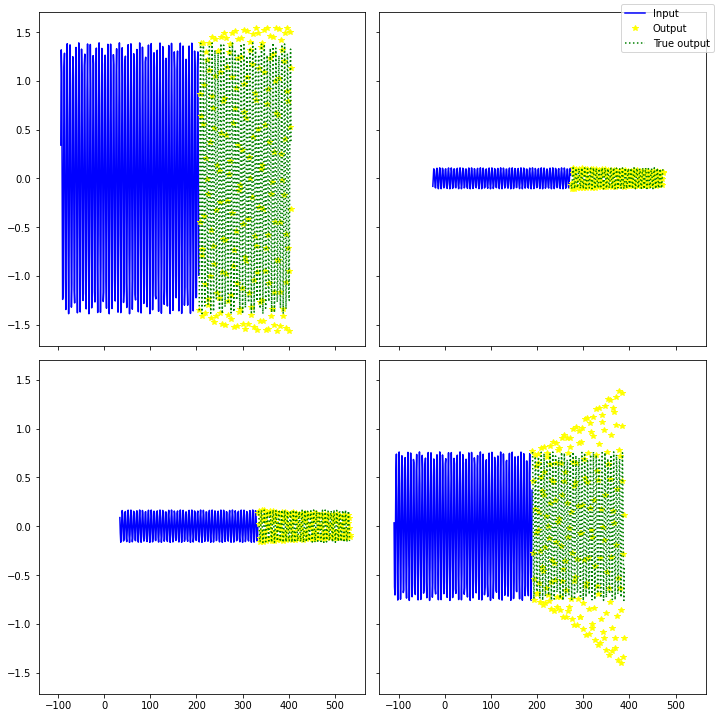

<IPython.core.display.Javascript object>

In [16]:
# sample_plot = 2
with torch.no_grad():
    y_pred = torch.zeros(y.size(0) + future, waves, 1, device=device)
    y_pred[: y.size(0)] = y
    for i in range(future):
        y_pred[y.size(0) + i] = model.forward(y_pred[: y.size(0) + i])
    print(
        f"With {future} predicted points on a batch of {waves} we get a loss of {loss_func(y_pred[y.size(0):], y_future):.2e}"
    )
    y_pred = y_pred.cpu().detach()
plots = 4
rows = 2
plot_indices = np.random.choice(np.arange(waves), size=[plots], replace=False)
fig, ax = plt.subplots(plots // rows, rows, figsize=[10, 10], sharex=True, sharey=True)
ax = ax.flatten()
# print(len(ax), waves)
for i, index in enumerate(plot_indices):
    ax[i].plot(x[:, index].cpu().detach(), y_pred[: y.size(0), index], color="blue")
    ax[i].plot(
        x_future[:, index].cpu().detach(),
        y_pred[y.size(0) :, index],
        "*",
        color="yellow",
    )
    ax[i].plot(
        x_future[:, index].cpu().detach(),
        y_future[:, index].cpu().detach(),
        ":",
        color="green",
    )
# plt.plot(x_plot)
fig.legend(["Input", "Output", "True output"])
fig.tight_layout()
plt.show()